# Построение модели кредитного скоринга
(Тестовое задание от "Отличные наличные")

Текст задания: "В файле данные по клиентам, которые получили онлайн займы.  В столбце Default  возврат займа обозначен цифрой 0, дефолт по займу - цифра 1. Алгоритм машинного обучения на ваше усмотрение."

In [303]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve, confusion_matrix

from functools import reduce
import warnings
warnings.filterwarnings("ignore")

RAND = 10

# Загрузка данных

In [355]:
df = pd.read_csv('for_test.csv', sep=';')

In [356]:
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Default,dtir1,CAC,CAD
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,CIB,25-34,to_inst,"98,72881356",south,direct,1,45.0,"109,73","100,729"
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EXP,55-64,to_inst,NaN,North,direct,1,NaN,10,4
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,CIB,35-44,to_inst,"80,01968504",south,direct,0,46.0,"100,02","82,02"
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,45-54,not_inst,"69,3768997",North,direct,0,42.0,"88,38","74,377"
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,25-34,not_inst,"91,88654354",North,direct,0,39.0,"106,89","92,887"


In [357]:
print('Размер датасета:{}'. format(df.shape))

Размер датасета:(2899, 33)


In [358]:
#Основные метрики для понимания датасета
full_info = pd.DataFrame(df.dtypes, columns=['Type'])
full_info['Unique_val'] = df.nunique()
full_info['Values'] = df.count(axis=0)
full_info['No_value'] = df.isna().sum(axis=0)
full_info['min'] = df.min(axis=0)
full_info['mean'] = df.mean(axis=0).round(decimals = 2)
full_info['max'] = df.max(axis=0)
full_info['median'] = df.median(axis=0)
full_info.sort_values(by=['Type', 'Unique_val'])

,Type,Unique_val,Values,No_value,min,mean,max,median
year,int64,1,2899,0,2019,2019.00,2019,2019.0
Default,int64,2,2899,0,0,0.25,1,0.0
loan_amount,int64,106,2899,0,26500,332950.50,2006500,306500.0
Credit_Score,int64,401,2899,0,500,702.40,900,701.0
ID,int64,2899,2899,0,24890,26339.00,27788,26339.0
term,float64,20,2897,2,96.0,336.19,360.0,360.0
dtir1,float64,57,2427,472,5.0,38.05,61.0,39.0
property_value,float64,165,2595,304,58000.0,499202.31,5808000.0,428000.0
income,float64,332,2729,170,0.0,6871.99,189360.0,5640.0
construction_type,object,1,2899,0,sb,NaN,sb,NaN


Резюме по предварительному анализу.
Данные о 2899 клиентах.
Всего 33 переменных, из них:

 -- 4 определены как целочисленные значения (при этом: 
**ID** - уникальные значения ID равны количеству строк, что говорит об отсутствии дубликатов: далее *удалим* этот столбец за неинформативность;
**year** имеет 1 значение - 2019 год: далее *удалим* этот столбец за неинформативность, 
**Default** является нашей целевой переменной; 
**Credit_Score и loan_amount** информативны для задачи классификации).

 -- 4 определены как значения с плавающей точкой, при этом у каждого значения есть пропущенные переменные:
**term** имеет 2 отсутствующих значения, что составляет малую долю в общем объеме, пропуски заменим самым часто встречающимся значением - модой;
**dtir1**, скорее всего означает Debt-To-Income Ratio, что очень важно, было бы идеально найти коррелирующую переменную (например, можно предположить, что этот показатель коррелирует со значением Credit_Score) и вывести недостающие значения через взаимосвязь, однако сейчас для упрощения расчетов примем *медианное* значения для пропусков (16,3% строк будет заменено);
**property_value и income** заменим на медианное значение (по показателям мин и макс значений разброс очень большой, поэтому есть вероятность выбросов и поэтому лучше использовать *медиану*), (10,5% и 5,9% значений будет заменено, соответственно)

 -- остальные 25 переменных определены object, при этом
**construction_type, Secured_by, Security_Type** имеют только одно уникальное значение: далее *удалим* эти столбцы за неинформативность;
10 переменных - бинарные, 8 переменных - категориальные, пропуски будут заполнены модальными значениями. Возраст указан как диапазон;
**LTV, CAC, CAD** - (Lifetime Value, Customer Acquisition Cost) - значения с плавающей точкой: далее изменим тип, пропуски у LTV заменим медианным значением (замена 10,5% значений)

Внесем описанные изменения

In [359]:
#Удаление неинформативных столбцов
df.drop(['year', 'ID', 'construction_type', 'Secured_by', 'Security_Type'], axis=1, inplace=True)

In [309]:
# Замена типа данных
df['LTV'] = df['LTV'].str.replace(',', '.').astype(float)
df['CAC'] = df['CAC'].str.replace(',', '.').astype(float)
df['CAD'] = df['CAD'].str.replace(',', '.').astype(float)

In [310]:
# Заполнение пустных значений
columns_fillNA = {
    'term': df.term.median(), 
    'dtir1': df.dtir1.median(), 
    'property_value': df.property_value.median(), 
    'income': df.income.median(), 
    'LTV': df.LTV.median(),
    'loan_limit': df.loan_limit.mode()[0], 
    'approv_in_adv': df.approv_in_adv.mode()[0], 
    'Neg_ammortization': df.Neg_ammortization.mode()[0], 
    'submission_of_application': df.submission_of_application.mode()[0], 
    'age': df.age.mode()[0]}

df.fillna(columns_fillNA, inplace=True)

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_limit                 2899 non-null   object 
 1   Gender                     2899 non-null   object 
 2   approv_in_adv              2899 non-null   object 
 3   loan_type                  2899 non-null   object 
 4   loan_purpose               2899 non-null   object 
 5   Credit_Worthiness          2899 non-null   object 
 6   open_credit                2899 non-null   object 
 7   business_or_commercial     2899 non-null   object 
 8   loan_amount                2899 non-null   int64  
 9   term                       2899 non-null   float64
 10  Neg_ammortization          2899 non-null   object 
 11  interest_only              2899 non-null   object 
 12  lump_sum_payment           2899 non-null   object 
 13  property_value             2899 non-null   float

Подробнее рассмотрим целевую переменную Default. 0 - возврат займа, 1 - дефолт по займу.

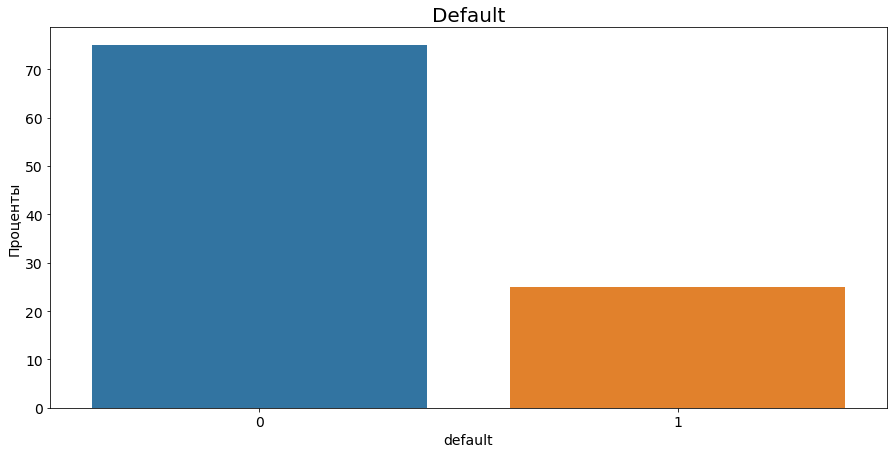

In [312]:
# нормирование на размер датасета
norm_target = (df
               .Default
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

plt.title('Default', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В датасете наблюдается дисбаланс классов, что нужно будет учитывать при построении модели

# Feature engineering

In [313]:
df.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'occupancy_type', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Default', 'dtir1',
       'CAC', 'CAD'],
      dtype='object')

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_limit                 2899 non-null   object 
 1   Gender                     2899 non-null   object 
 2   approv_in_adv              2899 non-null   object 
 3   loan_type                  2899 non-null   object 
 4   loan_purpose               2899 non-null   object 
 5   Credit_Worthiness          2899 non-null   object 
 6   open_credit                2899 non-null   object 
 7   business_or_commercial     2899 non-null   object 
 8   loan_amount                2899 non-null   int64  
 9   term                       2899 non-null   float64
 10  Neg_ammortization          2899 non-null   object 
 11  interest_only              2899 non-null   object 
 12  lump_sum_payment           2899 non-null   object 
 13  property_value             2899 non-null   float

In [315]:
numeric_columns = ['loan_amount', 'Credit_Score', 'term', 'dtir1', 'property_value', 'income', 'LTV', 'CAC', 'CAD']

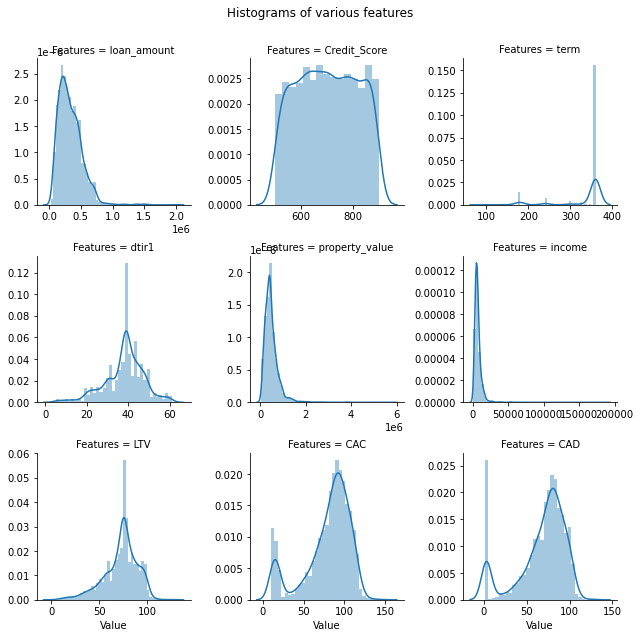

In [316]:
numeric_features = df[numeric_columns]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

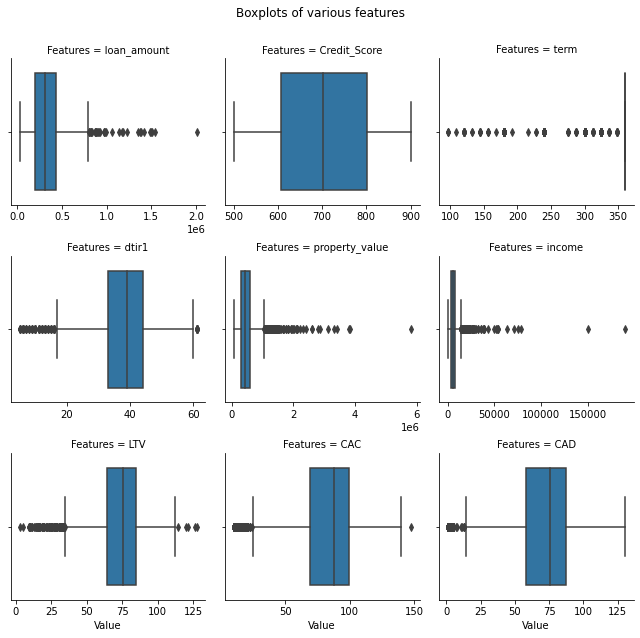

In [317]:
numeric_features = df[numeric_columns]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.boxplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Boxplots of various features");

Заметно, что loan_amount, term, property_value, income смещены преимущественно влево, что говорит о логнормальном распределении а 'CAC', 'CAD' имеют выбросы. В целях нормализации данных, чтобы данные были более симметричными, прологарифмируем эти показатели.

In [318]:
for i in ['loan_amount', 'term', 'property_value', 'income', 'CAC', 'CAD']:
    df[i] = np.log(df[i]+1)

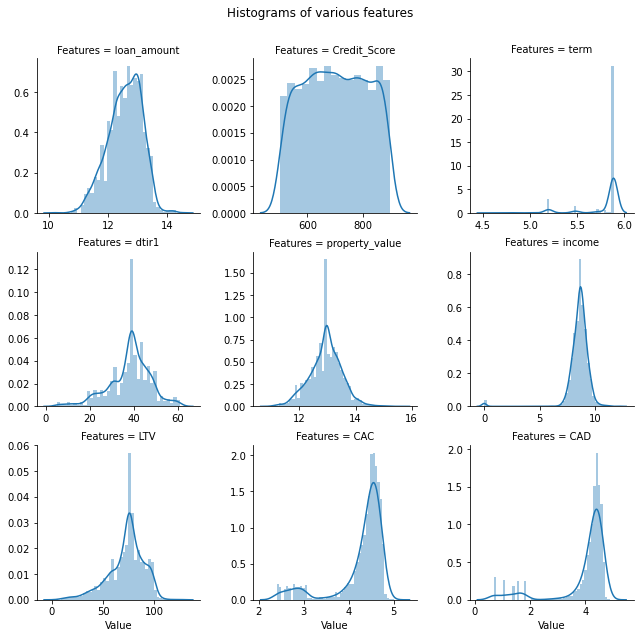

In [319]:
numeric_features = df[numeric_columns]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Видим, что распределения стали более симметричны и сместились в сторону.

Далее рассмотрим взаимосвязь между переменными для поиска сильно взаимосвязанных показателей.

Correlation

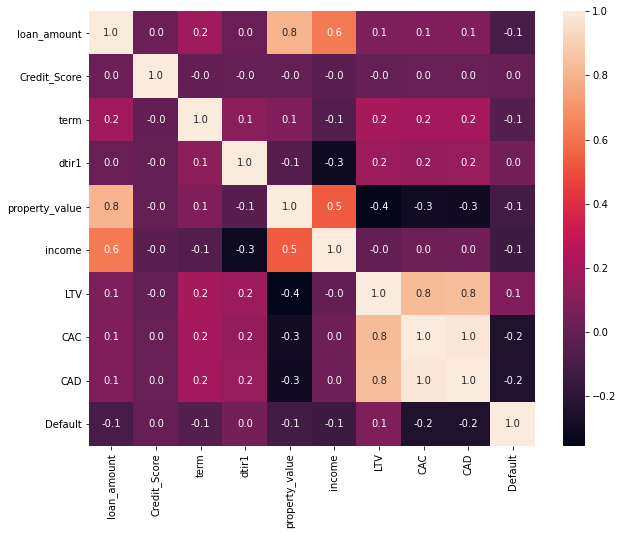

In [321]:
numeric_columns_with_target = ['loan_amount', 'Credit_Score', 'term', 'dtir1', 'property_value',
                               'income', 'LTV', 'CAC', 'CAD', 'Default']
plt.figure(figsize=(10, 8))

sns.heatmap(df[numeric_columns_with_target].corr(method='spearman'), annot=True, fmt=".1f");

При проверке данных на мультиколлинеарность, были выявлены сильно скоррелированные показатели (более 0,7):
- пара: CAD, CAC (и LTV)
- пара: property_value, loan_amount

Воспользуемся методом последовательного исключение показателей, исключаем те, которые слабее скорелированны с целевой переменной.
Из первой пары исключим CAD и LTV, из второй property_value

In [387]:
df.drop(['CAD', 'property_value', 'LTV'], axis = 1, inplace=True)

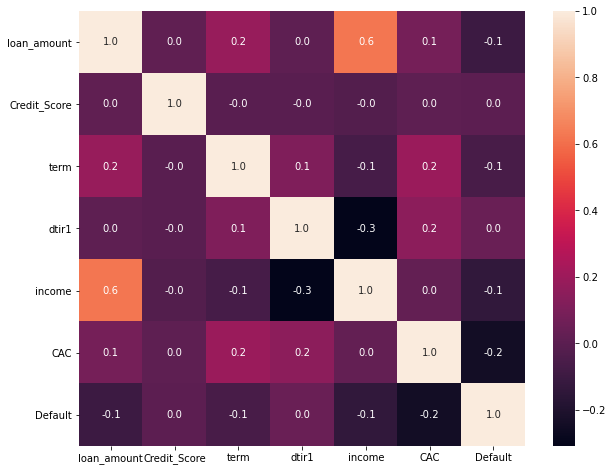

In [323]:
numeric_columns_with_target = ['loan_amount', 'Credit_Score', 'term', 'dtir1',
                               'income', 'CAC', 'Default']
plt.figure(figsize=(10, 8))

sns.heatmap(df[numeric_columns_with_target].corr(method='spearman'), annot=True, fmt=".1f");

Таким образом, мы рассмотрели распределение каждой переменной, и логарифмировали те показатели, которые были распределены логнормально. Также исключили взаимосвязанные переменные, после чего результаты моделирования станут чище.

Отметим основные характеристики категориальных переменных

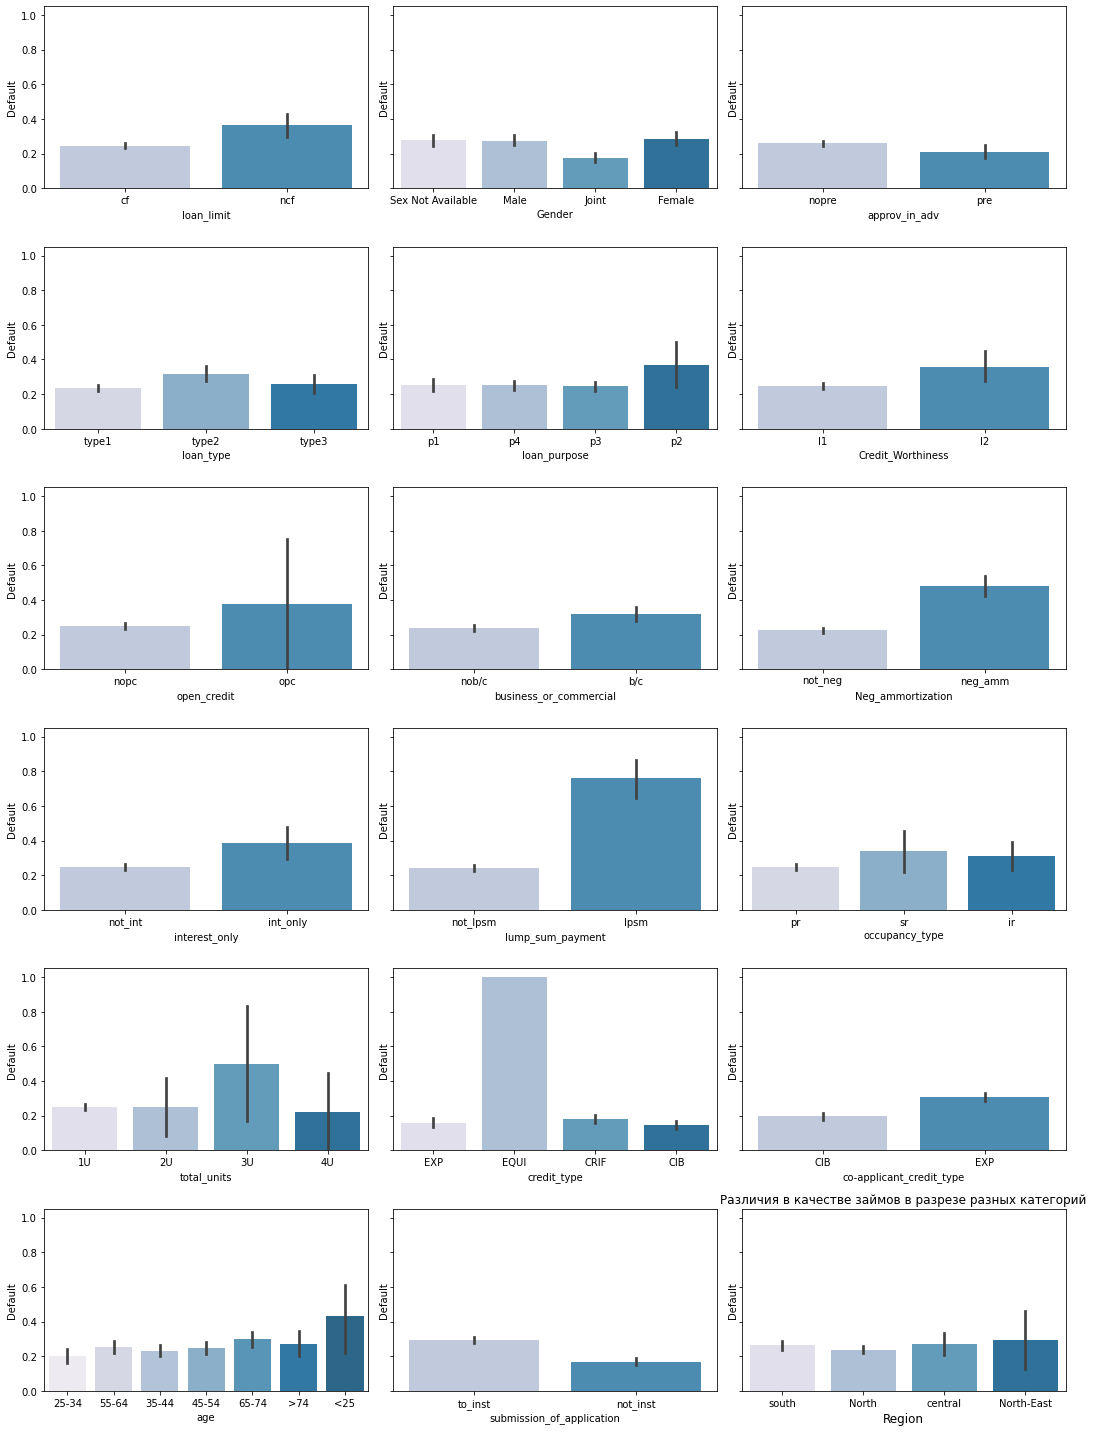

In [360]:
bool_cat_features = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'occupancy_type', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'Region']

fig, axes = plt.subplots(6, 3, figsize=(15,20), squeeze=False, sharey=True)

for i, ax in zip(bool_cat_features, axes.ravel()):
    sns.barplot(data=df, x=i, y='Default',alpha = 0.9, ax=ax, palette="PuBu")
    plt.xlabel(i, fontsize=12)
    
plt.title('Различия в качестве займов в разрезе разных категорий', fontsize=12) 
plt.tight_layout()  
#По оси "y" задана единая шкала от 0 до 1, чтобы графики были сопоставимы друг с другом.

Видно, что у каждой категории есть отличия по среднему уровню дефолта (т.е. более высокие столбцы (приближенные к 1), характеризуют категорию как "склонную к дефолту", а более низкие столбцы говорят о лучшем качестве заемщика).
Например, клиенты младше 25 лет, имеют бОльшую склонность к невыплате займа, чем клиенты других возрастов, а клиенты с полом "joint", наоборот, склонны к возврату займа.

# Моделирование

In [327]:
bool_cat_features = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'occupancy_type', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'Region']
numeric_columns = ['loan_amount', 'Credit_Score', 'term', 'dtir1','income', 'CAC']

In [362]:
#Преобразование категориальных переменных
df_label = pd.get_dummies(df, columns=bool_cat_features, drop_first=True)
df_label.rename(columns={'age_<25': 'age_less25', 'age_>74': 'age_more74'}, inplace=True)

In [400]:
X = df_label.drop('Default', axis=1)
y = df_label.Default

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

С целью классификации займа на дефолтный и недефолтный займ будем использовать логистическую регрессию. Она часто применяется для задач бинарной классификации и именно в рамках кредитного скоринга я часто встречала применение именно этой модели. 

Для начала построим базовую модель со сбалансированными классами. Далее подберем наилучшие параметры для текущей задачи.

Базовая модель

In [401]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

ValueError: could not convert string to float: '67,75766017'

In [333]:
metrics_for_comparison = pd.DataFrame(index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics_for_comparison['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        log_loss(y_test, y_pred)]

In [334]:
metrics_for_comparison

,Baseline_LR
roc-auc,0.780078
precision,0.600000
recall,0.626374
f1,0.612903
logloss,6.860199


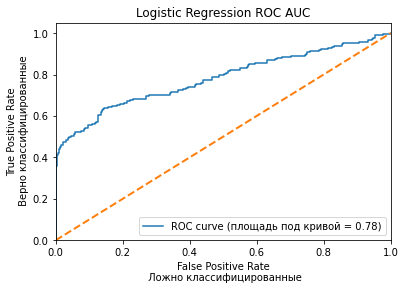

In [335]:
fpr, tpr, treashold = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'ROC curve (площадь под кривой = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate\n Ложно классифицированные')
plt.ylabel('True Positive Rate\n Верно классифицированные')

plt.title('Logistic Regression ROC AUC')
plt.legend(loc="lower right")

Площадь под кривой - 0,78 (чаще всего модель принимают, если показать выше 0,8) precision и recall примерно на однм уровне.

In [365]:
confusion_matrix(y_test, y_pred)

array([[511,  32],
       [ 71, 111]], dtype=int64)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

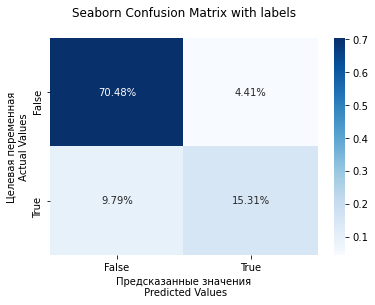

In [366]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('Предсказанные значения\n Predicted Values')
ax.set_ylabel('Целевая переменная\n Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

Постараемся улучшить качество логистической регрессии за счет подбора параметров

In [337]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [338]:
grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=1.0, l1_ratio=0.25, max_iter=100, pe

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([   1.  ,  250.75,  500.5 ,  750.25, 1000.  ]),
                         'l1_ratio': [0.25, 0.5, 0.75],
                         'max_iter': array([100, 200, 300, 400]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='roc_auc', verbose=2)

In [339]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8381549757055424
{'C': 500.5, 'l1_ratio': 0.25, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}


In [340]:
best_params = {'C': 500.5, 'l1_ratio': 0.25, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}

In [341]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

In [342]:
metrics_for_comparison['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [343]:
metrics_for_comparison[:-1].style.highlight_max(axis=1, color='lightblue')

,Baseline_LR,Grid_LR
roc-auc,0.780078,0.816344
precision,0.600000,0.649123
recall,0.626374,0.609890
f1,0.612903,0.628895


В итоге мы получили в целом более точную модель, roc-auc увеличился на 0,04, что является достаточным приростом, f-мера также показала прирост в основном за счет precision(точности), а вот по recall немного потеряла. 

Все зависит от целей бизнеса, если для бизнеса ошибка выдачи займа дефолтному клиенту будет очень дорого стоить, то нужно смотреть именно на recall. Если же нам важнее выдать больше, т.е. потери от выдачи дефолтным клиентам будут не так важны по сравнению с выручкой от возврата займа, то в приоритете precision.

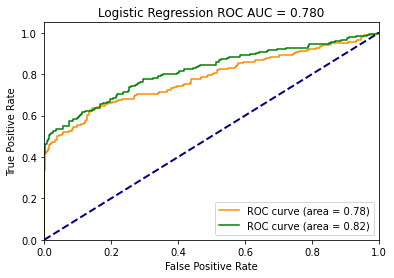

In [344]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [345]:
lr_gr.coef_

array([[ 6.66050882e-01, -4.13529140e-01, -7.25570918e-01,
         1.22880674e-03,  1.04067328e-02,  7.87512611e-01,
         6.60286933e-01, -4.38639524e-01,  6.74819788e-02,
        -7.05830683e-02, -9.43657964e-02,  6.93727930e-01,
         6.61369562e-02,  7.52480376e-01,  1.28068756e-01,
         3.04056835e-01,  8.89431442e-02, -3.90207653e-01,
        -1.46552154e-01, -1.03935169e+00, -1.12488056e+00,
        -3.59483627e+00, -1.32239443e+00, -2.33935104e-02,
        -3.10105903e-01,  3.67737287e-01,  3.33627462e-02,
         1.92464788e-01,  6.95772739e+00,  5.25196295e-02,
        -1.72252857e-01,  1.56657910e-01,  4.07717143e-02,
         2.25863171e-01,  2.94728417e-01,  1.30465352e+00,
         1.96212733e-01,  1.11244353e+00,  3.49384134e-01,
        -3.15810095e-01, -1.37780313e-02]])

Для оценки выбора модели попробуем сделать следующее. В рамках известных мне моделей (в некоторые из них я еще не углублялась) построим модели классификации датасета по предустановленным параметрам (где возможно установим балансировку классов и возможность многократного воспроизведения результатов). Далее выведем показатели качества моделей в таблицу. Считается что бустинговые модели должны работать лучше логистической регрессии.

In [347]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [348]:
#for catboost classifier
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [349]:
classifiers = [
    LogisticRegression(**best_params, class_weight='balanced', random_state=RAND),
    LinearSVC(random_state=RAND),
    SGDClassifier(class_weight='balanced', random_state=RAND),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(class_weight='balanced', random_state=RAND),
    RandomForestClassifier(class_weight='balanced',random_state=RAND),
    GradientBoostingClassifier(random_state=RAND),
    MLPClassifier(random_state=RAND),
    XGBClassifier(),
    CatBoostClassifier(class_weights=class_weights, random_state=RAND)
    ]
name = []
models = []
score = []
precision = []
recall = []
f1 = []
log_loss_s = []
i = 0


for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    name.append(type(classifier).__name__)
    models.append(classifier)
    score.append(classifier.score(X_test, y_test))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    log_loss_s.append(log_loss(y_test, y_pred))

[13:04:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.014353
0:	learn: 0.6831288	total: 2.87ms	remaining: 2.87s
1:	learn: 0.6749869	total: 48.2ms	remaining: 24.1s
2:	learn: 0.6661273	total: 51.4ms	remaining: 17.1s
3:	learn: 0.6582492	total: 55.2ms	remaining: 13.8s
4:	learn: 0.6495276	total: 57.6ms	remaining: 11.5s
5:	learn: 0.6410114	total: 60.7ms	remaining: 10.1s
6:	learn: 0.6325142	total: 63.9ms	remaining: 9.06s
7:	learn: 0.6246574	total: 67ms	remaining: 8.3s
8:	learn: 0.6167126	total: 70.8ms	remaining: 7.79s
9:	learn: 0.6119174	total: 74.2ms	remaining: 7.34s
10:	learn: 0.6059797	total: 92.8ms	remaining: 8.34s
11:	learn: 0.5992321	total: 95.8ms	remaining: 7.89s
12:	learn: 0.5935556	total: 124ms	remaining: 9.45

In [350]:
df_score = pd.DataFrame(list(zip(name, score, precision, recall, f1, log_loss_s, models)),\
                        columns=['name','score', 'precision', 'recall', 'f1', 'log_loss', 'model'])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['f1'],ascending=False, inplace=True)
df_score.style.highlight_max(axis=0, color='lightblue')

,score,precision,recall,f1,log_loss,model
name,,,,,,
CatBoostClassifier,0.857931,0.776224,0.609890,0.683077,4.906924,
GradientBoostingClassifier,0.864828,0.928571,0.500000,0.650000,4.668697,GradientBoostingClassifier(random_state=10)
XGBClassifier,0.857931,0.869159,0.510989,0.643599,4.906904,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', validate_parameters=1, verbosity=None)"
LogisticRegression,0.819310,0.649123,0.609890,0.628895,6.240866,"LogisticRegression(C=500.5, class_weight='balanced', l1_ratio=0.25, max_iter=400, random_state=10)"
DecisionTreeClassifier,0.815172,0.639535,0.604396,0.621469,6.383787,"DecisionTreeClassifier(class_weight='balanced', random_state=10)"
GaussianNB,0.838621,0.777778,0.500000,0.608696,5.573873,GaussianNB()
MLPClassifier,0.855172,0.952941,0.445055,0.606742,5.002172,MLPClassifier(random_state=10)
RandomForestClassifier,0.855172,0.963855,0.439560,0.603774,5.002171,"RandomForestClassifier(class_weight='balanced', random_state=10)"
LinearSVC,0.844138,0.879121,0.439560,0.586081,5.383297,LinearSVC(random_state=10)


Как видно лучше всего даже с предустановленными параметрами работает CatBoostClassifier, он выигрывает все модели по показателю f-меры и recall, при этом recall совпадает с полученным значением в логистической регрессии.

Модель градиентного бустинга лучше всех определяет данные на тестовом наборе, и у нее очень высокий precision, т.е. он определяет точно, но полнота охвата нужных клиентов слабее других моделей. И у него самая низкая функция потерь.

В целом, логистическая регрессия показала удовлетворительный результат, коэффициенты при переменных можно перевести в шансы, что относительно легко для понимания.